# This notebooks does predictive modeling of the Output : "Is there any opp of Abuse?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [40]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\574977\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read the extract files, with balanced data, check the number of records, first few rows

In [2]:
filename = "C:\\Users\\574977\\Downloads\\PycharmProjects\\pepsico\\shymal\\Input files\\oppAbuse/Base LCS Files Extract_28 Aug 2019_207Files.xlsm"

In [3]:
filename5 = "C:\\Users\\574977\\Downloads\\PycharmProjects\\pepsico\\shymal\\Input files\\oppAbuse/MLextracts_abuseByConsumer 08 26.xlsm"

In [5]:
df_abuse_yes = pd.read_excel(filename5)

In [6]:
df_abuse_no = pd.read_excel(filename)

In [7]:
len(df_abuse_yes)

23

In [8]:
len(df_abuse_no)

207

In [9]:
df_abuse_no=df_abuse_no[(df_abuse_no['abuseByConsumer']=='No')]

In [10]:
len(df_abuse_no)

204

In [11]:
df_abuse_yes.abuseByConsumer.value_counts()

Yes    23
Name: abuseByConsumer, dtype: int64

In [12]:
#Concatenate yes and no samples
df = pd.concat([df_abuse_no,df_abuse_yes])

# Select key features for oppOfAbuse choice 

In [13]:
df.fillna('NA', inplace=True)

features_df=df[['PDA_projName', 'projDesc','formulaNumber','CPD-ProdName-Desc','packMaterial','prodStorageDist','shelfLife',
    'TCG','cookedOrHeated', 'specificStorage','labelingInstructions','mishandled','targetMarket','approvedPackage']]

In [14]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)

features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))  
features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))
features_df['formulaNumber']=features_df['formulaNumber'].apply(lambda x:conv_str(x)) 
features_df['packMaterial']=features_df['packMaterial'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['prodStorageDist']=features_df['prodStorageDist'].apply(lambda x:conv_str(x)) 
features_df['shelfLife']=features_df['shelfLife'].apply(lambda x:conv_str(x))  
features_df['TCG']=features_df['TCG'].apply(lambda x:conv_str(x)) 
features_df['cookedOrHeated']=features_df['cookedOrHeated'].apply(lambda x:conv_str(x)) 
features_df['specificStorage']=features_df['specificStorage'].apply(lambda x:conv_str(x)) 
features_df['labelingInstructions']=features_df['labelingInstructions'].apply(lambda x:conv_str(x)) 
features_df['mishandled']=features_df['mishandled'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x)) 
features_df['approvedPackage']=features_df['approvedPackage'].apply(lambda x:conv_str(x)) 

# Concatenate the columns as one single text value

In [15]:
features_df['concat_text'] = features_df['PDA_projName']+" "+features_df['projDesc']+" "+features_df['formulaNumber']+" "+features_df['packMaterial']+" "+features_df['CPD-ProdName-Desc']+" "+features_df['prodStorageDist']+" "+features_df['shelfLife']+" "+features_df['TCG']+" "+features_df['cookedOrHeated']+" "+features_df['specificStorage']+" "+features_df['labelingInstructions']+" "+features_df['mishandled']+" "+features_df['targetMarket']+" "+features_df['approvedPackage']

# Find the number of tokens in the text

In [16]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

21549

We have over 21k words in the data.

# Find the value counts of target Field (Yes / No)

In [17]:
df.abuseByConsumer.value_counts()

No     204
Yes     23
Name: abuseByConsumer, dtype: int64

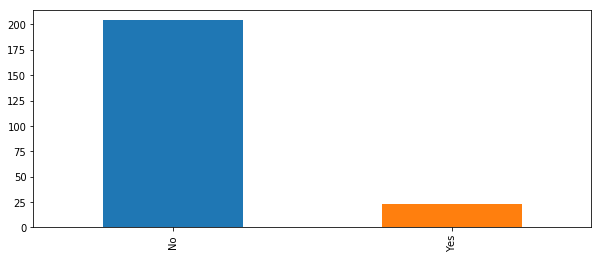

In [18]:
plt.figure(figsize=(10,4))
df.abuseByConsumer.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [19]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [20]:
features_df["tags"] = impute_target(df,"abuseByConsumer")

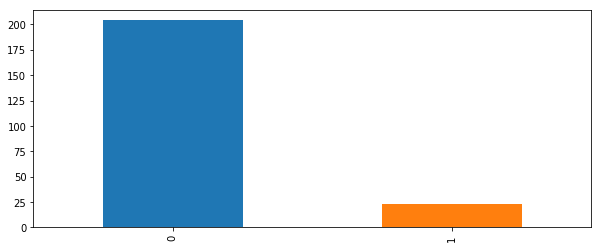

In [21]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [22]:
features_df.tags.value_counts()

0    204
1     23
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [23]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [24]:
print_plot(10)

simba creamy cheddar ruffles potato chips sodium reduction project to conform to legislative requirements in south africa. there are no new hazard or allergens being introduced to the plant.  the seasoning does not require the process to be modified.  the packaging material and pack format remain as per current. simba potato chips (zbr for different flavoured products) existing film construction ready to eat snack - potato chips ambient storage & distribution 16 weeks - sa market, 26 weeks - export market lsm 4-7 gen-x families no - ready to eat snack no - store in a cool dry place at ambient temperature store in a cool dry place no - however, if left open will absorb moisture no vulnerable groups no
Tag: 0


In [25]:
print_plot(5)

simba cheese & onion ruffles potato chips sodium reduction project to conform to legislative requirements in south africa. there are no new hazard or allergens being introduced to the plant.  the seasoning does not require the process to be modified.  the packaging material and pack format remain as per current. simba potato chips (zbr for different flavoured products) existing film construction ready to eat snack - potato chips ambient storage & distribution 16 weeks - sa market, 26 weeks - export market lsm 4-7 gen-x families no - ready to eat snack no - store in a cool dry place at ambient temperature store in a cool dry place no - however, if left open will absorb moisture no vulnerable groups no
Tag: 0


# Clean the text (remove punctuation, symbols, lowercase etc)

In [41]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [42]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [43]:
print_plot(0)

lays wavy spring onion lays wavy sour cream significant launch new subline within existing pc brand ridged wavy lays bal q3 2018 launch regular flavors onion fromage ridged pc base permanently produced grodzisk plant p02806 pp03084 pf03211 none ips ridged potato bases keep cool dry away sun place 18 + 1 week 15 35 yo
Tag: 0


In [44]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

14539

# Train Test Split

In [45]:
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [46]:
y_train.value_counts()

0    163
1     18
Name: tags, dtype: int64

In [47]:
y_test.value_counts()

0    41
1     5
Name: tags, dtype: int64

In [48]:
y_test = y_test.reset_index()
y_test = y_test['tags']

# Upsample the target data, since the data is highly imbalanced

In [49]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_oppAbuse = X[X.tags==0]
oppAbuse = X[X.tags==1]

In [50]:
len(not_oppAbuse)

163

In [51]:
len(oppAbuse)

18

In [52]:
# upsample minority
oppAbuse_upsampled = resample(oppAbuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_oppAbuse), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([oppAbuse_upsampled, not_oppAbuse])

In [53]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    163
0    163
Name: tags, dtype: int64

In [54]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [56]:
#y_train=y_train.reshape(y_train.shape[0],1)

In [57]:
y_train.shape

(326,)

In [58]:
X_train.shape

(326, 1)

In [59]:
X_train['concat_text'].values[10]

'power new quaker porridge go breakfast drink convenient way get goodness quaker oats delicious drinkeach drink combination superfine milled quaker oats creamy milk fruit porridge go breakfast drink contains 100 wholegrain oats source fibre calcium protein artificial colours flavours preservativesavailable following varieties vanilla bean red berries apple blueberry na power milk oat fruit drink ambient 6 month health conscious 25 35 year olds refrigerated shake well opening open keep refrigerated dispose 3 days yes'

In [60]:
X_train = X_train['concat_text'].values

In [61]:
X_train[10]

'power new quaker porridge go breakfast drink convenient way get goodness quaker oats delicious drinkeach drink combination superfine milled quaker oats creamy milk fruit porridge go breakfast drink contains 100 wholegrain oats source fibre calcium protein artificial colours flavours preservativesavailable following varieties vanilla bean red berries apple blueberry na power milk oat fruit drink ambient 6 month health conscious 25 35 year olds refrigerated shake well opening open keep refrigerated dispose 3 days yes'

In [62]:
X_test.values[0]

'simba potato chips sodium reduction project conform legislative requirements south africa new hazard allergens introduced plant seasoning require process modified packaging material pack format remain per current simba potato chips zbr different flavoured products existing film construction ready eat snack potato chips ambient storage distribution 16 weeks sa market 26 weeks export market lsm 47 genx families ready eat snack store cool dry place ambient temperature store cool dry place however left open absorb moisture vulnerable groups'

In [63]:
X_test = X_test.values

In [64]:
X_test[1]

'doritos bits doritos bits go consumption existing base recipe 2 seasonings existing line packaging bag size shape change material structure gauge change na none fritos category corn chips taco extreme seasonings fried palm olein oil keep cool dry away sun place 4 months young adults adult na keep away direct sunlight heat warning please eat carefully risk choking onto bag na na'

In [65]:
y_train[5]

0

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2),max_df=0.8,min_df=0.1,max_features=10000)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=0.8))])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=0.1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True))])

In [67]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        41
          1       1.00      0.60      0.75         5

avg / total       0.96      0.96      0.95        46

Wall time: 7.51 ms


In [68]:
print(np.where(y_test==1))

(array([ 1, 15, 29, 41, 45], dtype=int64),)


In [69]:
print(np.where(y_pred==1))

(array([29, 41, 45], dtype=int64),)


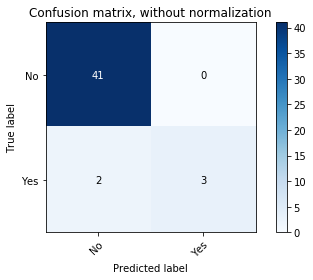

In [71]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [72]:
X = np.concatenate((X_train,X_test))

In [73]:
len(X)

372

In [74]:
X=X.reshape(X.shape[0],)

In [76]:
#y_test=y_test.reshape(y_test.shape[0],1)

In [77]:
y = np.concatenate((y_train,y_test))

In [78]:
y=y.reshape(y.shape[0],)

In [79]:
from sklearn.model_selection import cross_validate
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,cv=5)

In [80]:
print(cv_results['test_score'])

[1.   1.   1.   1.   0.97]


### SGDClassifier

In [83]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=10000)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l1',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        stri...ty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [84]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        41
          1       1.00      0.60      0.75         5

avg / total       0.96      0.96      0.95        46

Wall time: 9.03 ms


In [85]:
sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
cv_results = cross_validate(sgd.fit(X, y), X, y,cv=5)
print(cv_results['test_score'])

[1.   1.   1.   1.   0.97]


### Logistic regression

In [86]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=10000)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e3)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        stri...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [87]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        41
          1       1.00      0.60      0.75         5

avg / total       0.96      0.96      0.95        46

Wall time: 10 ms


In [88]:
logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=1, C=1e5))])
cv_results = cross_validate(logreg.fit(X, y), X, y,cv=5)
print(cv_results['test_score'])

[1.   1.   1.   1.   0.97]


In [89]:
from sklearn.ensemble import RandomForestClassifier

randomForest = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100))
               ])
randomForest.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [90]:
%%time

y_pred = randomForest.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        41
          1       1.00      0.60      0.75         5

avg / total       0.96      0.96      0.95        46

Wall time: 10 ms


# Feature importance plot using chi-square

In [91]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(features_df['concat_text'])
#X_tfidf_no = tfidf.fit_transform(train_df_no['all_cols'])
y= features_df["tags"]
#y_no = train_df_no['Target']
chi2score = chi2(X_tfidf, y)[0]
#chi2score_no = chi2(X_tfidf_no, y_no)[0]

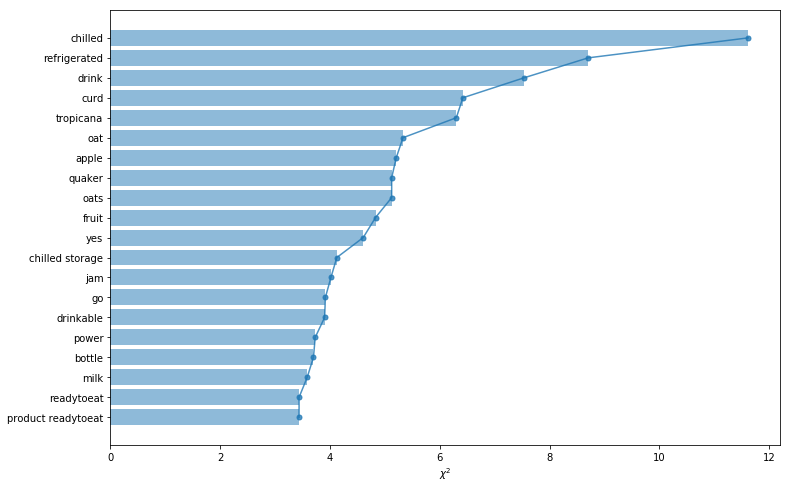

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
#print(scores)
chi2 = sorted(scores, key=lambda x:x[1])
#print(chi2)
topchi2 = list(zip(*chi2[-20:]))
#print(topchi2)
x = range(len(topchi2[1]))
#print(x)
labels = topchi2[0]
#print(labels)
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

#list_corpus = clean_questions["text"].tolist()
#list_labels = clean_questions["class_label"].tolist()

#X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
#                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [227]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         n_jobs=1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [228]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

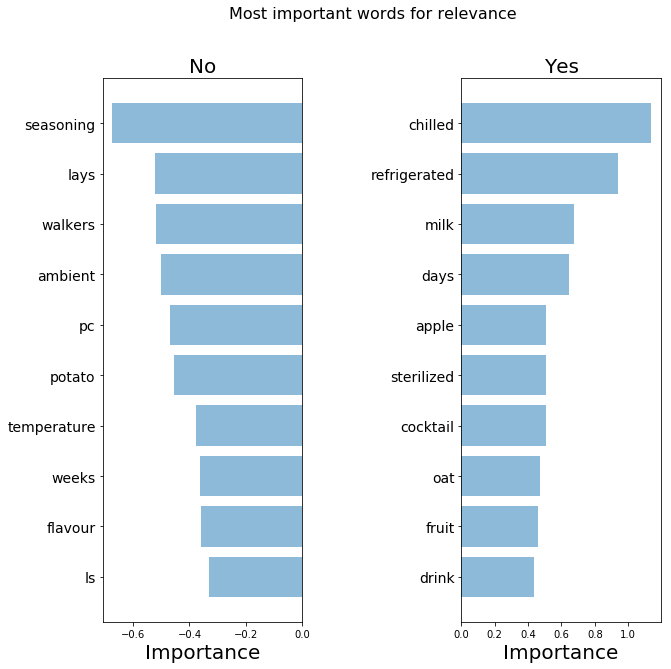

In [232]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('No', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Yes', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")